# How to solve H(div) PDEs in practice?

This document explores the current, easily accessible, state of the art for solving an $H(\rm div) \times L^2$ formulation of Poisson's problem or equivalently Darcy flow using FEniCS (www.fenicsproject.org) and underlying linear algebra libraries e.g. PETSc.

## Mathematical background

### Poisson's equation
The underlying PDE in question is: given $f$, find $p$ satisfying

  $- \Delta p = f$ 

over a computational domain $\Omega$ with homogeneous Dirichlet boundary conditions where $\Delta$ is the standard Laplace operator.

### Primal formulation
The standard (primal) $H^1$ formulation of this problem reads as: find $p \in H^1_0$ such that

  $\int_{\Omega} \nabla p \cdot \nabla q \, \textrm{d} x = \int_{\Omega} f q \, \textrm{d} x$

for all $q \in H^1_0$. Usual finite element spaces for this formulation is for instance Lagrange elements of order $k \geq 1$ i.e. continuous piecewise polynomials of polynomial order $k$ defined relative to a mesh of the domain.

### Mixed formulation
The standard (mixed) $H(\rm div) \times L^2$ formulation of this problem reads as: find $u \in H(\rm div)$ and $p \in L^2$ such that

  $\int_{\Omega} u \cdot v + \nabla \cdot u q + \nabla \cdot v p \, \textrm{d} x = \int_{\Omega} - f q \, \textrm{d} x$ 

Stable finite elements for this formulation is for instance Raviart-Thomas elements of order $k+1$ and discontinuous elements of order $k$ for $k \geq 0$. 


## Implementation basics 

The implementation is based on the FEniCS finite element software and its Python interface:

In [1]:
# Import useful libraries
from dolfin import *
import numpy
import pylab

# Plot inline in this notebook
%matplotlib inline

# Set basic optimization parameters for FEniCS
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["cpp_optimize"] = True

Some code snippets for running solves, timing them and running repeated solves and reporting timing averages and standard deviations

In [2]:
def time_solve(mesh, algorithm):
    """Run a given algorithm over a given mesh, 
    time it and return the time and the dimension of the linear system."""
    
    solution, tag = algorithm(mesh)
    times = timings(TimingClear_clear, [TimingType_wall])
    dim = solution.function_space().dim()
    t = times.get_value(tag, "wall tot")

    return (t, dim)

def time_solves(mesh, algorithm, R=1):
    """Run R solves of a given algorithm over a given mesh, 
    time each and return average time and standard deviation."""
    
    times = numpy.empty(R)
    h = mesh.hmax()
    for i in range(R):
        t, dim = time_solve(mesh, algorithm)
        print "%s (s) with N=%d and h=%.2g: %.3g" % (algorithm, dim, h, t)
        times[i] = t

    avg_t = numpy.mean(times)
    std_t = numpy.std(times)

    return (avg_t, std_t)

## Implementation and study of primal formulation 

For comparison purposes, it is useful to look at run times for a relatively straightforward implementation of the primal formulation. So, code is included for this first:

In [3]:
def primal(mesh, tag):
    """Compute linear system corresponding to H^1 formulation,
    return matrix A, right-hand side b and Function for the solution."""
    
    Q = FunctionSpace(mesh, "CG", 1)
    p = TrialFunction(Q)
    q = TestFunction(Q)

    a = inner(grad(p), grad(q))*dx
    f = Constant(1.0)
    L = f*q*dx

    bc = DirichletBC(Q, 0.0, "on_boundary")

    A, b = assemble_system(a, L, bc)

    p = Function(Q)
    return (A, b, p)

### Solving the linear system using LU

The very basic method for solving the resulting system of equations is by direct LU factorization. Let's just look at that first. The below code snippet just extracts the primal formulation linear system, solves and times it: 

In [4]:
def primal_lu(mesh):
    """On given mesh, solve H^1 formulation using plain LU."""

    tag = "Primal LU"
    A, b, p = primal(mesh, tag)

    timer = Timer(tag)
    solver = LUSolver(A)
    solver.solve(p.vector(), b)
    timer.stop()

    return (p, tag)

Ok, so let's just run some timings with this formulation to see how long it takes and how the run time scales with mesh size and/or problem size i.e. number of degrees of freedom. 

In [5]:
sizes = [8, 16, 32]
hs = []
times = []
stds = []
Ns = []

R = 3

for n in sizes:
    mesh = UnitCubeMesh(n, n, n)
    Ns += [mesh.num_vertices()] # NB CG1 specific
    hs += [mesh.hmax()]
   
    avg_t, std_t = time_solves(mesh, primal_lu, R=R)
    print "%s took %0.3g (+- %0.3g)" % ("Primal LU", avg_t, std_t)

    times += [avg_t]
    stds += [std_t]

<function primal_lu at 0x7f6cea525d70> (s) with N=729 and h=0.22: 0.00562
<function primal_lu at 0x7f6cea525d70> (s) with N=729 and h=0.22: 0.00513
<function primal_lu at 0x7f6cea525d70> (s) with N=729 and h=0.22: 0.00535
Primal LU took 0.00537 (+- 0.000203)
<function primal_lu at 0x7f6cea525d70> (s) with N=4913 and h=0.11: 0.106
<function primal_lu at 0x7f6cea525d70> (s) with N=4913 and h=0.11: 0.11
<function primal_lu at 0x7f6cea525d70> (s) with N=4913 and h=0.11: 0.108
Primal LU took 0.108 (+- 0.00187)
<function primal_lu at 0x7f6cea525d70> (s) with N=35937 and h=0.054: 9.33
<function primal_lu at 0x7f6cea525d70> (s) with N=35937 and h=0.054: 9.38
<function primal_lu at 0x7f6cea525d70> (s) with N=35937 and h=0.054: 9.45
Primal LU took 9.39 (+- 0.0483)


Ok, let's plot the run times versus mesh size

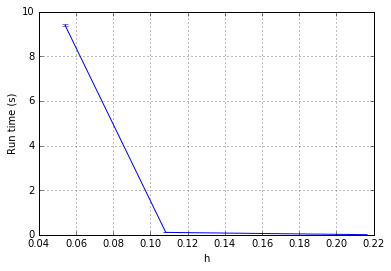

In [6]:
pylab.figure()
pylab.errorbar(hs, times, stds)
pylab.grid(True)
pylab.xlabel("h")
pylab.ylabel("Run time (s)")
pylab.show()

Or, we can look at run times versus problem size (number of degrees of freedom)

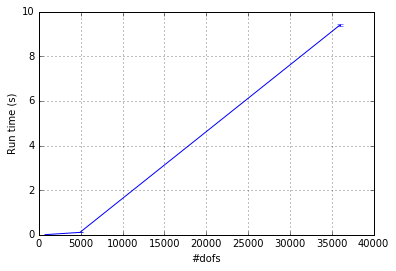

In [7]:
pylab.figure()
pylab.errorbar(Ns, times, stds)
pylab.grid(True)
pylab.xlabel("#dofs")
pylab.ylabel("Run time (s)")

pylab.show()

### Using AMG instead of LU for the primal formulation

Ok, so we can very easily do much better than using LU for this formulation. An obvious choice is to use built-in CG (symmetric problem) with AMG preconditioning out of the box. Here is a short code snippet for doing so and timing the result: 

In [8]:
def primal_amg(mesh):
    "Solve primal H^1 formulation using CG with AMG."

    tag = "Primal AMG"
    A, b, p = primal(mesh, tag)

    timer = Timer(tag)
    solver = PETScKrylovSolver("cg", "amg")
    solver.set_operator(A)
    num_it = solver.solve(p.vector(), b)
    timer.stop()

    print "%s: num_it = " % tag, num_it
    return (p, tag)

Let's do the same as we did for the LU, run some timings, and plot the results versus mesh size and problem size.Let's also try with N=64 since that should be completely feasible with an iterative solver.  

Primal AMG: num_it =  3
<function primal_amg at 0x7f6cb2f80848> (s) with N=729 and h=0.22: 0.00956
Primal AMG: num_it =  3
<function primal_amg at 0x7f6cb2f80848> (s) with N=729 and h=0.22: 0.0104
Primal AMG: num_it =  3
<function primal_amg at 0x7f6cb2f80848> (s) with N=729 and h=0.22: 0.00951
Primal AMG took 0.00981 (+- 0.000386)
Primal AMG: num_it =  3
<function primal_amg at 0x7f6cb2f80848> (s) with N=4913 and h=0.11: 0.103
Primal AMG: num_it =  3
<function primal_amg at 0x7f6cb2f80848> (s) with N=4913 and h=0.11: 0.108
Primal AMG: num_it =  3
<function primal_amg at 0x7f6cb2f80848> (s) with N=4913 and h=0.11: 0.111
Primal AMG took 0.107 (+- 0.00346)
Primal AMG: num_it =  3
<function primal_amg at 0x7f6cb2f80848> (s) with N=35937 and h=0.054: 2.18
Primal AMG: num_it =  3
<function primal_amg at 0x7f6cb2f80848> (s) with N=35937 and h=0.054: 2.14
Primal AMG: num_it =  3
<function primal_amg at 0x7f6cb2f80848> (s) with N=35937 and h=0.054: 2.11
Primal AMG took 2.14 (+- 0.0266)
Primal 

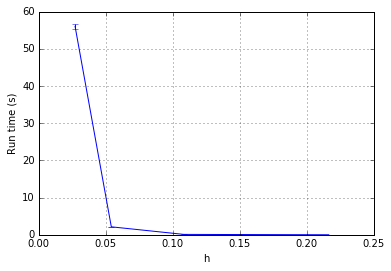

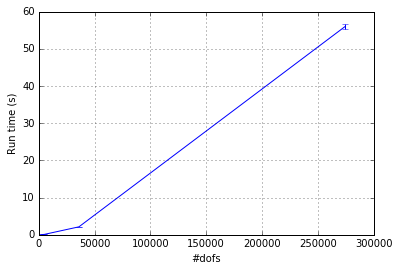

In [10]:
sizes = [8, 16, 32, 64]
hs = []
times = []
stds = []
Ns = []

R = 3

for n in sizes:
    mesh = UnitCubeMesh(n, n, n)
    Ns += [mesh.num_vertices()] # NB CG1 specific
    hs += [mesh.hmax()]
   
    avg_t, std_t = time_solves(mesh, primal_amg, R=R)
    print "%s took %0.3g (+- %0.3g)" % ("Primal AMG", avg_t, std_t)

    times += [avg_t]
    stds += [std_t]

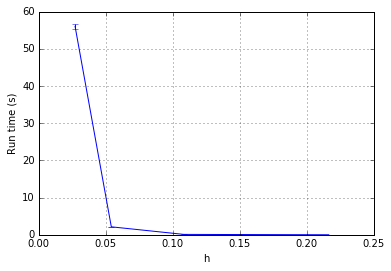

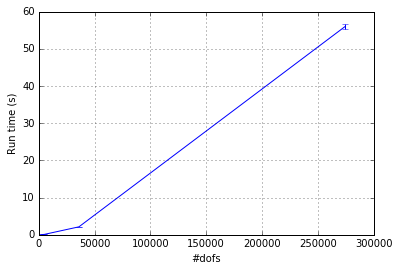

In [11]:
pylab.figure()
pylab.errorbar(hs, times, stds)
pylab.grid(True)
pylab.xlabel("h")
pylab.ylabel("Run time (s)")
pylab.show()

pylab.figure()
pylab.errorbar(Ns, times, stds)
pylab.grid(True)
pylab.xlabel("#dofs")
pylab.ylabel("Run time (s)")

pylab.show()

A quick look at these results indicates that 
* AMG beats LU run times around #dofs = 5000 (16 x 16 x 16 mesh) and onwards (increasing problem size);
* AMG run times increase with roughly a factor 20 when the mesh increases with a factor 10. 
* AMG for 32 x 32 x 32 takes about 2 seconds 

## Implementation and exploration of the mixed formulation

In [12]:
def darcy(mesh):
    """Compute and return linear system and solution function for mixed H(div) x L^2 formulation of Poisson/Darcy."""
    
    V = FiniteElement("RT", mesh.ufl_cell(), 1)
    Q = FiniteElement("DG", mesh.ufl_cell(), 0)
    W = FunctionSpace(mesh, V*Q)

    (u, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)

    a = (dot(u, v) + div(u)*q + div(v)*p)*dx
    f = Constant(-1.0)
    L = f*q*dx

    A = assemble(a)
    b = assemble(L)
    w = Function(W)

    return A, b, w

In [15]:
def darcy_lu(mesh):
    "Solve mixed H(div) x L^2 formulation using LU"
    
    tag = "Darcy LU"
    (A, b, w) = darcy(mesh)

    timer = Timer(tag)
    solve(A, w.vector(), b)
    timer.stop()

    return (w, tag)

With this mixed variational formulation of the problem and the basic LU solver, let's run some similar experiments 

In [17]:
sizes = [8, 16]
hs = []
times = []
stds = []
Ns = []

R = 3

for n in sizes:
    mesh = UnitCubeMesh(n, n, n)
    mesh.init()
    Ns += [mesh.num_edges() + mesh.num_cells()] # NB: RT0 x DG0 specific
    hs += [mesh.hmax()]
   
    avg_t, std_t = time_solves(mesh, darcy_lu, R=R)
    print "%s took %0.3g (+- %0.3g)" % ("Darcy LU", avg_t, std_t)

    times += [avg_t]
    stds += [std_t]

<function darcy_lu at 0x7f6cb2de6578> (s) with N=9600 and h=0.22: 0.144
<function darcy_lu at 0x7f6cb2de6578> (s) with N=9600 and h=0.22: 0.139
<function darcy_lu at 0x7f6cb2de6578> (s) with N=9600 and h=0.22: 0.14
Darcy LU took 0.141 (+- 0.00213)
<function darcy_lu at 0x7f6cb2de6578> (s) with N=75264 and h=0.11: 13.3
<function darcy_lu at 0x7f6cb2de6578> (s) with N=75264 and h=0.11: 13.2
<function darcy_lu at 0x7f6cb2de6578> (s) with N=75264 and h=0.11: 13.5
Darcy LU took 13.3 (+- 0.114)


Some observations:
* While LU for the primal formulation on the 8 x 8 x 8 mesh took 0.00537 s, LU for mixed on same mesh takes about 0.141 s which is a factor 20 increase. One can note however that N = 729 for the former and N = 9600 for the latter, which is a factor 10 increase in system size. 
* Running with 32 x 32 x 32 runs out of memory. 
